In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [24]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_users = nn.Embedding(nb_users + 1, mf_dim)
        self.mf_items = nn.Embedding(nb_items + 1, mf_dim)
        self.mlp_users = nn.Embedding(nb_users + 1, mlp_layer_sizes[0] // 2)
        self.mlp_items = nn.Embedding(nb_items + 1, mlp_layer_sizes[0] // 2)
        
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        mlp_layers = []
        for i in range(len(mlp_layer_sizes) - 1):
            mlp_layers.append(nn.Linear(mlp_layer_sizes[i], mlp_layer_sizes[i + 1]))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(p=dropout))
        self.mlp = nn.Sequential(*mlp_layers)
        self.final = nn.Linear(mf_dim + mlp_layer_sizes[-1], 1)
        
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn
        self.mf_users.weight.data.normal_(0., 0.01)
        self.mf_items.weight.data.normal_(0., 0.01)
        self.mlp_users.weight.data.normal_(0., 0.01)
        self.mlp_items.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        user_emb_mf = self.mf_users(user)
        item_emb_mf = self.mf_items(item)
        mf_vector = user_emb_mf * item_emb_mf

        user_emb_mlp = self.mlp_users(user)
        item_emb_mlp = self.mlp_items(item)
        mlp_vector = torch.cat((user_emb_mlp, item_emb_mlp), dim=-1)
        mlp_vector = self.mlp(mlp_vector)

        vector = torch.cat((mf_vector, mlp_vector), dim=-1)
        output = self.final(vector)
        if sigmoid:
            output = torch.sigmoid(output)
        return output

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [25]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        neg_users = ratings[:,0].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,0], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,1]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,1], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,1], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,1], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [26]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=10):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for users, items, labels in tqdm_notebook(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            outputs = model(users, items, sigmoid=True).squeeze()
            loss = loss_fn(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for users, items, labels in tqdm_notebook(test_loader, desc=f"Testing Epoch {epoch+1}"):
                outputs = model(users, items, sigmoid=True).squeeze()
                loss = loss_fn(outputs, labels.float())
                running_loss += loss.item()

        avg_test_loss = running_loss / len(test_loader)
        test_loss.append(avg_test_loss)
    return train_loss, test_loss

In [27]:
# Hyperparameters
nb_users = 943
nb_items = 1682
mf_dim = 8
mlp_layer_sizes = [64, 32, 16, 8]
dropout = 0.2
batch_size = 256
num_epochs = 20
learning_rate = 0.001

train_dataset = ML100kDataset('ml-100k/u1.base', negative_samples=4)
test_dataset = ML100kDataset('ml-100k/u1.test', negative_samples=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)






In [28]:
train_loss, test_loss = train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs)

C:\Users\Arkadiusz\AppData\Local\Temp\ipykernel_16700\1105696654.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for users, items, labels in tqdm_notebook(train_loader, desc=f"Training Epoch {epoch+1}"):


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\Arkadiusz\AppData\Local\Temp\ipykernel_16700\1105696654.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for users, items, labels in tqdm_notebook(test_loader, desc=f"Testing Epoch {epoch+1}"):


Testing Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 20:   0%|          | 0/391 [00:00<?, ?it/s]

### Plot results

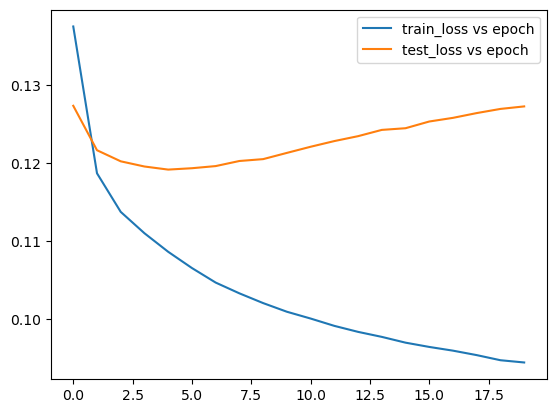

In [29]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()